# Finding pumps that give locally optimal spectral purity

This notebook showcases a local optimization scheme applied on mode purity for SPDC phenomenon in waveguides. The optimization will use penalty method with the average number of photon pairs generated per pulse as a constraint and the spectral purity of generated pair and the variance of the pump as the objective function. 2 seeds are used; one that is a Hermite polynomial multiplied by a Gaussian and a random vector.

## Theory

The dynamics describing SPDC can be seen as 

$\frac{\partial }{\partial z}a_S(z, \omega) = \text{i}\omega \Delta k_S a_S(z, \omega) + \frac{\text{i}\gamma (z)}{\sqrt{2\pi}}\int \beta (\omega + \omega ')a_I^\dagger (z, \omega ')d\omega ',\\
\frac{\partial }{\partial z}a_I^\dagger(z, \omega) = -\text{i}\omega \Delta k_I a_I ^\dagger(z, \omega) - \frac{\text{i}\gamma ^* (z)}{\sqrt{2\pi}}\int \beta ^* (\omega + \omega ')a_S(z, \omega),$

where $\Delta k_j = \frac{1}{v_j} - \frac{1}{v_p}$, where $v_j$ is the group velocity of the mode $j$, $\omega$ the frequency, $\beta(\omega)$ the slowly varying envelope of the pump in frequency domain, $\gamma (z)$ a tophat function associated to second order nonlinearity and $a_j (z, \omega)$ the annihilation operator for the mode $j$. The equations can be described by discretization into normal modes as

$
\frac{\partial}{\partial z}\begin{bmatrix}
\bar{a}_S(z, \omega)\\
\bar{a}_I^\dagger(z, \omega)
\end{bmatrix}=
\text{i}\begin{bmatrix}
\Delta k_S \omega & \beta \\
-\beta ^\dagger & -\Delta k_I \omega
\end{bmatrix}
\begin{bmatrix}
\bar{a}_S(z, \omega')\\
\bar{a}_I^\dagger(z, \omega')
\end{bmatrix} = \text{i}A\begin{bmatrix}
\bar{a}_S(z, \omega')\\
\bar{a}_I^\dagger(z, \omega')
\end{bmatrix} ,
$

where $\Delta k_j \omega$ is a diagonal matrix for both values of $j$ and $\beta$ a Hankel matrix representing $\beta (\omega + \omega')$. The matrix $A$ is an element of the Lie algebra and is used to generate the propagator associate to the dynamics which will be an element of the group $SU(1,1)$.

The spectral purity of SPDC dynamics in frequency and space domain for a waveguide can be represented by the Schmidt number $K$, which can be expressed by

$
\begin{align}
K = \frac{\text{Tr}\left[U_{SI}^*U_{SI}^{T}\right]^2}{\text{Tr}\left[U_{SI}^*U_{SI}^{T}U_{SI}^*U_{SI}^{T}\right]},
\end{align}
$

where $U_{SI}$ is a block of the matrix $U$, which is an element of the group $SU(1,1)$. The constraint that the average photon number pairs is equal to $n$, which in this notebook will be 3, can be written as

$\text{Tr}\left[U_{SI}^* U_{SI}^T\right] - n = 0$,

which also used the matrix $U_{SI}$. The matrix $U$ can be obtained by exponentiating $A$ such as

$
U = 
\begin{bmatrix}
U_{SS} & U_{SI}\\
U_{IS}^* & U_{II}^*
\end{bmatrix}
=
\text{exp}\left(\text{i}\begin{bmatrix}
\Delta k_S \omega & \beta \\
-\beta ^\dagger & -\Delta k_I \omega
\end{bmatrix}\right)
$

Because the theoretical minimum of the Schmidt number is 1, the objective function becomes $K-1$ and the problem becomes

$
\begin{align}
\text{min} \ & \frac{\text{Tr}\left[U_{SI}^*U_{SI}^{T}\right]^2}{\text{Tr}\left[U_{SI}^*U_{SI}^{T}U_{SI}^*U_{SI}^{T}\right]} - 1\\
\text{s. c.} \ & \text{Tr}\left[U_{SI}^* U_{SI}^T\right] - n = 0,\\
& \begin{bmatrix}
U_{SS} & U_{SI}\\
U_{IS}^* & U_{II}^*
\end{bmatrix}
=
\text{exp}\left(\text{i}\begin{bmatrix}
\Delta k_S \omega & \beta \\
-\beta ^\dagger & -\Delta k_I \omega
\end{bmatrix}\right).
\end{align}
$

## Import the libraries 

The library used to generate initial seed, to optimize the spectral purity and to post-process the data are imported.

In [1]:
import jax.numpy as jnp
import jax
import jaxopt
import numpy as np

import matplotlib.pyplot as plt

import optimization_SPDC as opt
import get_initialization_cond as init

key = jax.random.PRNGKey(0)

# Set general hyperparameters

Hyperparameters are set to generate the propagator describing the dynamics of SPDC and to make the optimization scheme. They include the discretized frequency domain vector, the strength and parameters used to generate the initial pump seed, the group frequency of the pump mode, the length of the nonlinear material and the number of pairs generated per pulse.

In [2]:
Np = 0.01
# higher N and wf+wi makes less unstable pump... need to see if N or wf+wi influences more
N = 601
wi = -10
wf = 10
x = jnp.linspace(wi, wf, N)
freq_range_pump = jnp.linspace(2*wi, 2*wf, 2*N)
freq_range_pump_complex = jnp.concatenate((freq_range_pump, freq_range_pump)).reshape(4*N,)
vp = 0.1
l = 1
# Parameters to generate pump seed
hermite_order = 2
gaussian_amplitude = 0.05
gaussian_width = 0.3
phase = jnp.pi/5
hermite_init_params = [hermite_order, gaussian_amplitude, gaussian_width, phase]
cst_init_params = [0.1]
y_N = 3

Using the initialization module, the diagonal blocks $\Delta k_j \omega$ of the propagator generator are generated as well as the seeds used to effect the optimization scheme

In [3]:
alpha, G, H = init.get_constants(vp, l, wi, wf, Np, N = N)
arbitrary_seed_hermite = init.get_initialization_array(hermite_init_params, vp, l, wi, wf, Np, method='hermite', N = N)
random_seed = Np*jax.random.uniform(key, shape=(4*N,))

Subgradient descent will be used with a penalty method algorithm on random seed as well as on a Hermitian polynomial multiplied by a Gaussian. The $\sigma _k$ value will be $3^k$.

In [4]:
solver = jaxopt.PolyakSGD(opt.get_penalty_loss, maxiter=40, verbose = 0, jit = False)

In [6]:
pump = random_seed.copy()
for i in range(20):
    print("run " + str(i))
    (pump, state) = solver.run(pump, N, alpha, G, H, l, y_N, freq_range_pump, 3**i)

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14
run 15
run 16
run 17
run 18
run 19


Now, let us see what happens if we were to use the Hermitian polynomial multiplied with the Gaussian instead. 

In [7]:
hermitian_pump = arbitrary_seed_hermite.copy()
for i in range(15):
    print("run " + str(i))
    (hermitian_pump, state) = solver.run(hermitian_pump, N, alpha, G, H, l, y_N, freq_range_pump, 3**i)

run 0
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 11
run 12
run 13
run 14


Here we will plot out the absolute value of the optimal pump when the seed is random and when the seed is a Hermitian polynomial multiplied by a Gaussian

In [25]:
abs_pump = jnp.abs(opt.get_complex_array(pump))
abs_hermit_pump = jnp.abs(opt.get_complex_array(hermitian_pump))
phase_pump = jnp.angle(opt.get_complex_array(pump))
phase_hermit_pump = jnp.angle(opt.get_complex_array(hermitian_pump))
display_plot = [abs_pump, abs_hermit_pump, phase_pump, phase_hermit_pump]
display_leg = ["absolute value with random pump", "absolute value with Hermitian pump", "phase value with random pump", "phase value with Hermitian pump"]

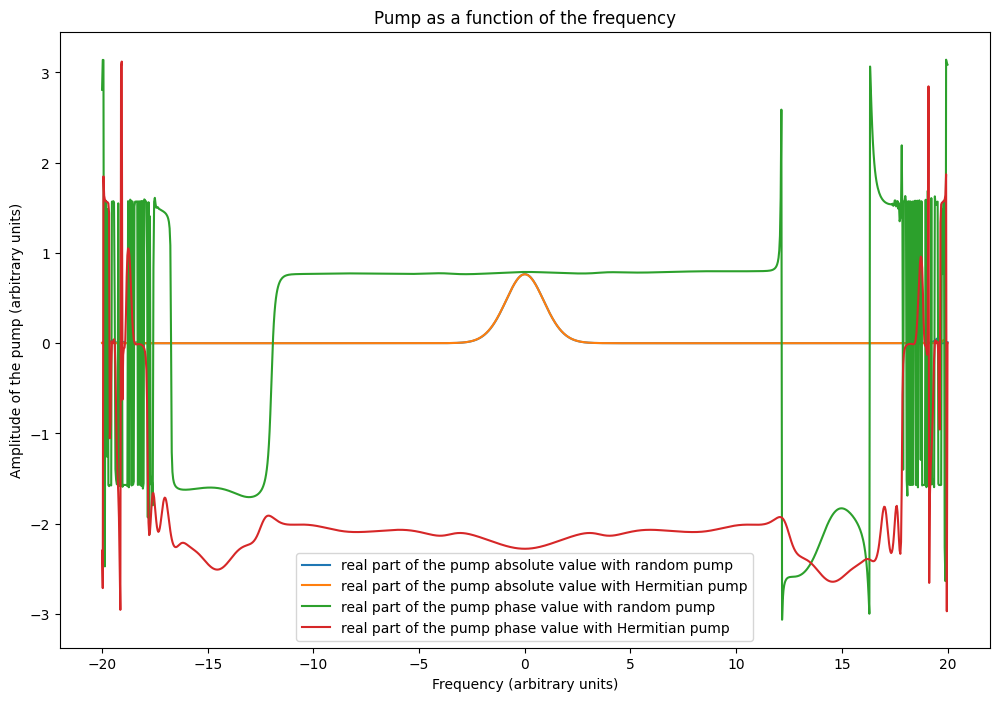

In [26]:
import display_res as disp

disp.plot_pump(display_plot, freq_range_pump, display_leg)

And the purity for the optimal pump with random seed and Hermitian seed are respectively

In [31]:
print("Schmidt number with random seed: ", opt.get_observables(pump, N, alpha, G, H, l)[1])
print("Schmidt number with Hermitian seed: ", opt.get_observables(hermitian_pump, N, alpha, G, H, l)[1])

Schmidt number with random seed:  1.1177903
Schmidt number with Hermitian seed:  1.1173829


We can see that after optimization, the absolute value of the optimal pump initialized with random seed and Hermitian seed overlap. This overlapping shape also looks Gaussian. One would then be led to believe 2 things; first that the lower bound on the Schmidt number for an average pair number per pulse of 3 is 1.12 and second that the optimal pump seems to be Gaussian. Let us see if the second point hold.
Horaire

Du 6 mai au 8 juin 2023 :
Lundi au jeudi 	7 h 45 à 20 h
Vendredi 	7 h 45 à 18 h
Samedi et dimanche 	Fermé

La bibliothèque sera fermée le lundi 22 mai 2023 pour la Journée nationale des patriotes et exceptionnellement le jeudi 1er juin 2023.

Du 9 juin au 18 juin 2023 :
Lundi au jeudi 	7 h 45 à 20 h
Vendredi 	8 h 30 à 12 h 30
Samedi et dimanche 	Fermé

Du 19 juin au 2 juillet 2023 :
Lundi au mercredi 	7 h 45 à 17 h
Jeudi 	8 h 30 à 12 h 30
Vendredi, samedi et dimanche 	Fermé

## Optimization of a Gaussian

Now, suppose the optimal pump is truly Gaussian, only 3 parameters are needed, which are the amplitude of the Gaussian, its width and the phase for a complex pump. Let us generate the seeds for these 3 parameters. First, we need to import the modules to realize the optimization scheme.

In [7]:
import optimization_SPDC_gaussain_pump as opt_gauss

Now, let us use the same parameters for the Gaussian seed to generate an optimization scheme restricted to Gaussian pumps and the same solver as before with penalty method.

In [ ]:
params = [gaussian_amplitude, gaussian_width, phase]


# Experiment with $\left <N\right> = 1$

## Set $\left<N\right>$

In [3]:
y_N = 1

## Optimization with BFGS

In [17]:
#dont touch this
optimal_arbitrary_pump = (jax_opt.minimize(opt.get_loss, arbitrary_seed_hermite_order_1,args=(N, alpha, G, H, l, y_N), method = "BFGS")).x
optimal_arbitrary_complex_pump = opt.get_complex_array(optimal_arbitrary_pump)
optimal_arbitrary_pump_cst_seed = (jax_opt.minimize(opt.get_loss, arbitrary_cst_seed,args=(N, alpha, G, H, l, y_N), method = "BFGS")).x
optimal_arbitrary_pump_cst_seed_complex = opt.get_complex_array(optimal_arbitrary_pump_cst_seed)
optimal_gaussian_theta = (jax_opt.minimize(gauss_opt.get_loss,initial_value_gauss, args = (freq_range_pump, alpha, G, H, l, y_N), method="BFGS")).x
optimal_gaussian_pump = gauss_opt.get_gaussian_pump(optimal_gaussian_theta, freq_range_pump)

In [29]:
seed_1 = opt.get_complex_array(arbitrary_seed_hermite_order_1)
seed_2 = opt.get_complex_array(arbitrary_cst_seed)

# Test zone

In [ ]:
def penalized_obj_function(theta, freq_range, size: int, alpha, G, H, l, y_N):
    loss = opt.get_loss(theta, size, alpha, G, H, l, y_N)
    w = 1
    return loss + w*(sum(((wf-wi)/N)*freq_range*jnp.abs(theta)/jnp.linalg.norm(theta)))**2Avoiding explicit imports of NumPy is a non-goal for JAX.

In [ ]:
test_optimal_arbitrary_pump = (jax_opt.minimize(penalized_obj_function, arbitrary_seed_hermite_order_1, args=(freq_range_pump_for_real_and_complex, N, alpha, G, H, l, y_N), method="BFGS")).x

In [103]:
dirac = np.zeros(len(freq_range_pump_for_real_and_complex))
dirac[101] = -1
dirac[101+202] = -1

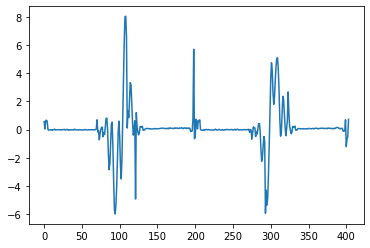

In [114]:
#penalty
plt.plot(test_optimal_arbitrary_pump)

## Plotting results

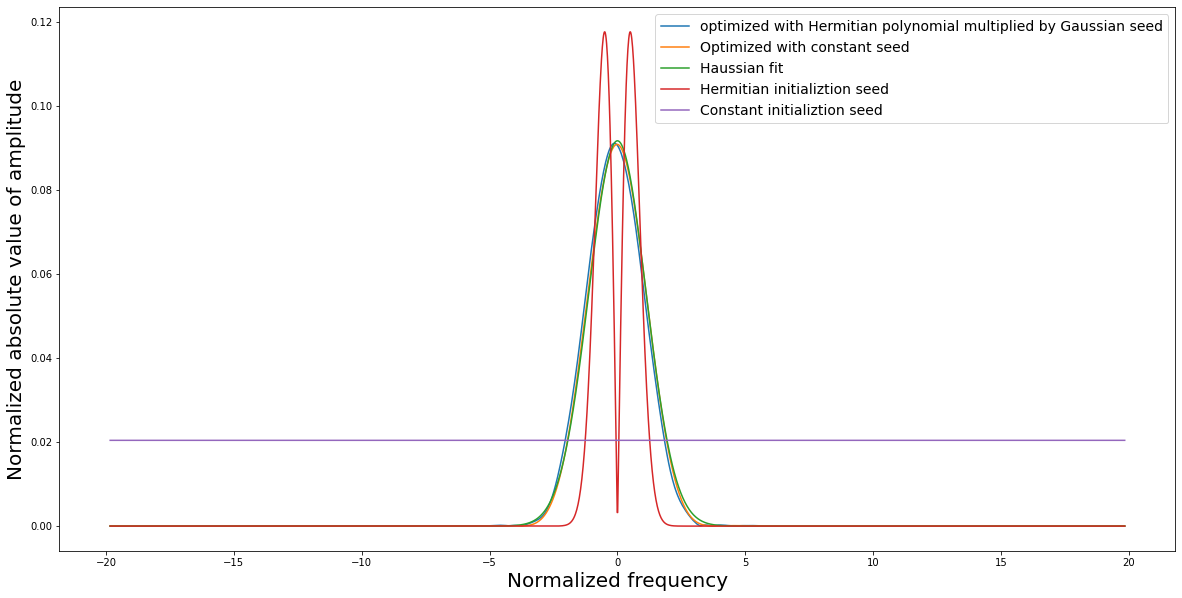

In [39]:
plt.figure(figsize=(20,10))
plt.plot(freq_range_pump[10:-10], (np.abs(optimal_arbitrary_complex_pump)/np.linalg.norm(optimal_arbitrary_complex_pump))[10:-10], label = "optimized with Hermitian polynomial multiplied by Gaussian seed")
plt.plot(freq_range_pump[10:-10], (np.abs(optimal_arbitrary_pump_cst_seed_complex)/np.linalg.norm(optimal_arbitrary_pump_cst_seed_complex))[10:-10], label = "Optimized with constant seed")
plt.plot(freq_range_pump[10:-10], (np.abs(optimal_gaussian_pump)/np.linalg.norm(optimal_gaussian_pump))[10:-10], label = "Haussian fit")
plt.plot(freq_range_pump[10:-10], (np.abs(seed_1)/np.linalg.norm(seed_1))[10:-10], label = 'Hermitian initializtion seed')
plt.plot(freq_range_pump[10:-10], (np.abs(seed_2)/np.linalg.norm(seed_2))[10:-10], label = 'Constant initializtion seed')
plt.xlabel("Normalized frequency",fontsize = 20)
plt.ylabel("Normalized absolute value of amplitude",fontsize = 20)
plt.legend(loc = 1,prop = {"size": 14})
plt.savefig("figabstract.pdf")

# Experimentation with many N values 

## Set all possible values of $\left<N\right>$

In [3]:
y_Ns = jnp.array([0.1, 0.5, 1, 2, 3, 4, 5])

## Optimization with BFGS

In [18]:
K_values_arbitrary = []
N_values_arbitrary = []
arbitrary_optimized_params = []
arbitrary_optimized_complex_params = []
K_values_gauss = []
N_values_gauss = []
gaussian_optimized_params = []
gaussian_optimized_complex_pump = []
for i in range(len(y_Ns)):
    optimized_arbitrary_pump = (jax_opt.minimize(opt.get_loss, arbitrary_seed_hermite_order_1, args = (N, alpha, G, H, l, y_Ns[i]), method="BFGS")).x
    arbitrary_optimized_params.append(optimized_arbitrary_pump)
    arbitrary_optimized_complex_params.append(opt.get_complex_array(optimized_arbitrary_pump))
    N_values_arbitrary.append(opt.get_observables(optimized_arbitrary_pump, N, alpha, G, H, l)[0])
    K_values_arbitrary.append(opt.get_observables(optimized_arbitrary_pump, N, alpha, G, H, l)[1])
    optimized_gaussian_params = (jax_opt.minimize(gauss_opt.get_loss, initial_value_gauss, args=(freq_range_pump, alpha, G, H, l, y_Ns[i]), method= "BFGS")).x
    gaussian_optimized_params.append(optimized_gaussian_params)
    gaussian_optimized_complex_pump.append(optimized_gaussian_params[0]*jnp.exp(-(freq_range_pump*optimized_gaussian_params[1])**2)*jnp.exp(1j*optimized_gaussian_params[2]))
    K_values_gauss.append(gauss_opt.get_observable(optimized_gaussian_params, freq_range_pump, alpha, G, H, l)[1])
    N_values_gauss.append(gauss_opt.get_observable(optimized_gaussian_params, freq_range_pump, alpha, G, H, l)[0])
    print("Finished " + str(y_Ns[i]) + " number of pairs created")

Finished 0.1 number of pairs created
Finished 0.5 number of pairs created
Finished 1.0 number of pairs created
Finished 2.0 number of pairs created
Finished 3.0 number of pairs created
Finished 4.0 number of pairs created
Finished 5.0 number of pairs created


## Plotting results

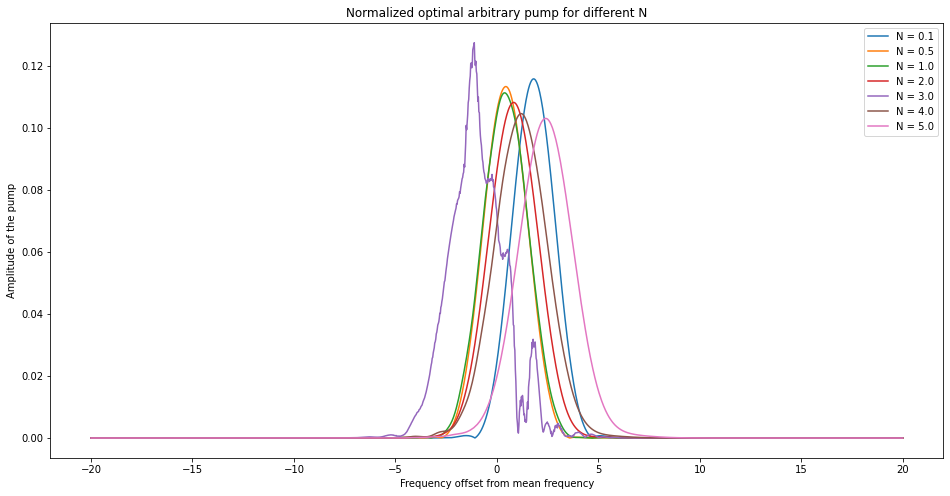

In [19]:
plt.figure(figsize = (16,8))
plt.title("Normalized optimal arbitrary pump for different N")
plt.xlabel("Frequency offset from mean frequency")
plt.ylabel("Amplitude of the pump")
for i in range(len(arbitrary_optimized_params)):
    plt.plot(w, jnp.abs(arbitrary_optimized_complex_params[i]/jnp.linalg.norm(arbitrary_optimized_complex_params[i])), label = "N = "+str(y_Ns[i]))
plt.legend()

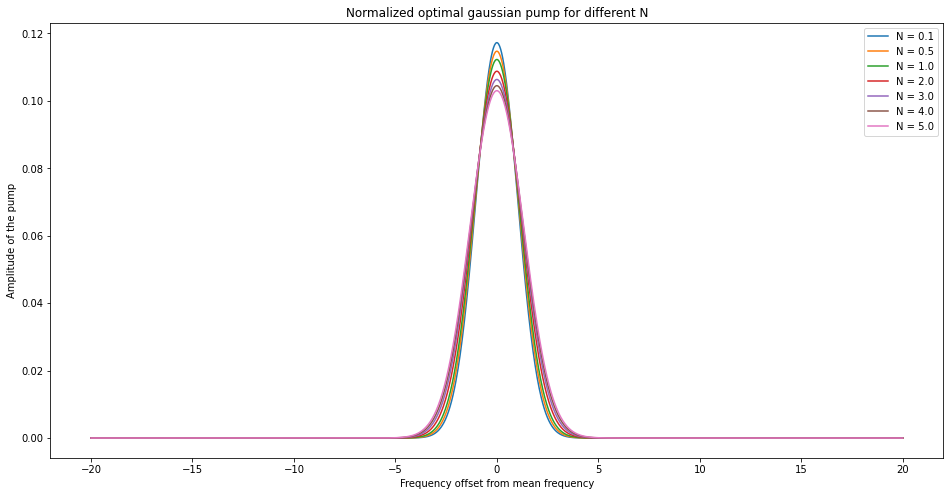

In [20]:
plt.figure(figsize = (16,8))
plt.title("Normalized optimal gaussian pump for different N")
plt.xlabel("Frequency offset from mean frequency")
plt.ylabel("Amplitude of the pump")
for i in range(len(arbitrary_optimized_params)):
    plt.plot(freq_range_pump, jnp.abs(gaussian_optimized_complex_pump[i]/jnp.linalg.norm(gaussian_optimized_complex_pump[i])), label = "N = "+str(y_Ns[i]))
plt.legend()

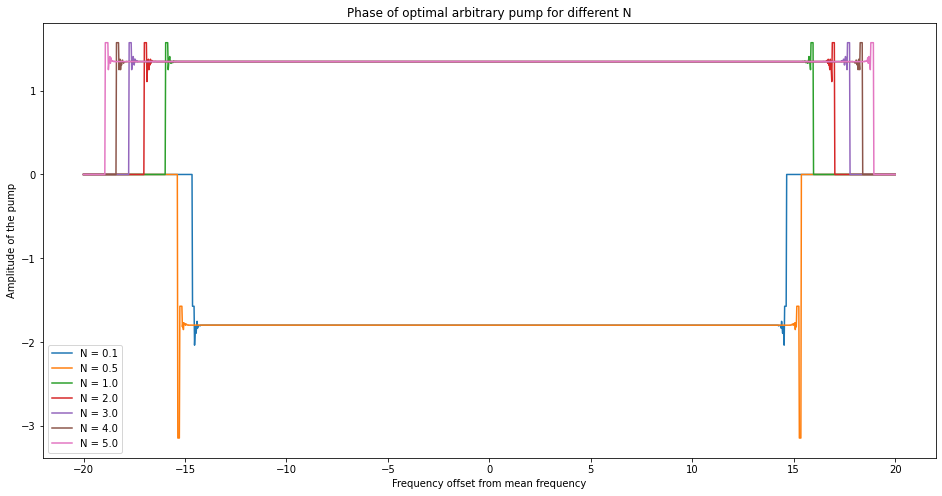

In [7]:
plt.figure(figsize = (16,8))
plt.title("Phase of optimal arbitrary pump for different N")
plt.xlabel("Frequency offset from mean frequency")
plt.ylabel("Amplitude of the pump")
for i in range(len(arbitrary_optimized_params)):
    plt.plot(freq_range_pump, jnp.angle(gaussian_optimized_complex_pump[i]/jnp.linalg.norm(gaussian_optimized_complex_pump[i])), label = "N = "+str(y_Ns[i]))
plt.legend()

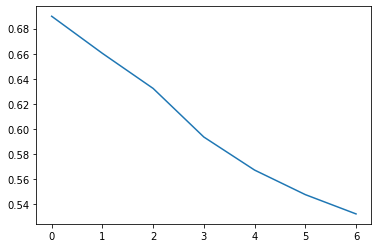

In [28]:
plt.plot(np.array(gaussian_optimized_params).T[1])

In [25]:
K_values_gauss, K_values_arbitrary

([DeviceArray(1.2017771, dtype=float32),
  DeviceArray(1.169891, dtype=float32),
  DeviceArray(1.1422957, dtype=float32),
  DeviceArray(1.1083034, dtype=float32),
  DeviceArray(1.0880771, dtype=float32),
  DeviceArray(1.0745721, dtype=float32),
  DeviceArray(1.064865, dtype=float32)],
 [DeviceArray(1.1986483, dtype=float32),
  DeviceArray(1.1691366, dtype=float32),
  DeviceArray(1.1420541, dtype=float32),
  DeviceArray(1.1079186, dtype=float32),
  DeviceArray(1.1463771, dtype=float32),
  DeviceArray(1.074201, dtype=float32),
  DeviceArray(1.0638047, dtype=float32)])

## Save results and plots

In [32]:
save.save_data(N, wi, wf, Np, vp, l , y_Ns, arbitrary_optimized_params, "gauss_hermite_first_order", arbitrary_seed_hermite_order_1, 1, False)

In [31]:
y_Ns

DeviceArray([0.1, 0.5, 1. , 2. , 3. , 4. , 5. ], dtype=float32)

# Example of unstable pump

In [4]:
unstable_init_hermite_params = [1, 1, 1, jnp.pi/5]
initial_unstable_arbitrary_seed = init.get_initialization_array(unstable_init_hermite_params, vp, l, wi, wf, Np, method = "hermite", N = N)

In [5]:
unstable_opt_arbitrary_pump = (jax_opt.minimize(opt.get_loss, initial_unstable_arbitrary_seed, args = (N, alpha, G, H, l, y_N), method="BFGS")).x

In [6]:
unstabl_opt_arbitrary_complex_pump = opt.get_complex_array(unstable_opt_arbitrary_pump)Avoiding explicit imports of NumPy is a non-goal for JAX.

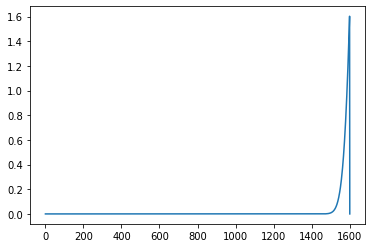

In [7]:
plt.plot(np.abs(unstabl_opt_arbitrary_complex_pump))